## Description

This notebook explores the architecture with the constraint $\widetilde{Z} = \Omega Z$, tests out the SMPC algorithm on manifold learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, trange
from src.plot_utils import scatter_plot_2d
from src.utils import soft_threshold, power_method_svd
from scipy.linalg import sqrtm
import src.models_old as models
from src.loss import SMPC_loss, SimilarityLossDL
# plt.style.use('seaborn-whitegrid')

In [3]:
import seaborn as sns
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.0, rc={"text.usetex":True})
# sns.set_context("paper", font_scale=1.5)
# sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# sns.axes_style("whitegrid", {'grid.linestyle': '--'},)

In [4]:
# # Default rc params
# # rc_params_orig = mpl.rcParams.copy()

# # Set rcParams
# mpl.rcParams['figure.figsize'] = (8, 6)
# # mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['lines.linewidth'] = 2.0
# mpl.rcParams['lines.markersize'] = 8
# mpl.rcParams['font.family'] = 'sans-serif'
# # mpl.rcParams['font.sans-serif'] = ''

In [21]:
seed = 42
np.random.seed(seed)
T = 100
N = 2
noise = 0.01
# A = ortho_group.rvs(dim=N)
K = 12
runtime_params = {
    'K': K,
    'N': N,
    'T': T,
}
A

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

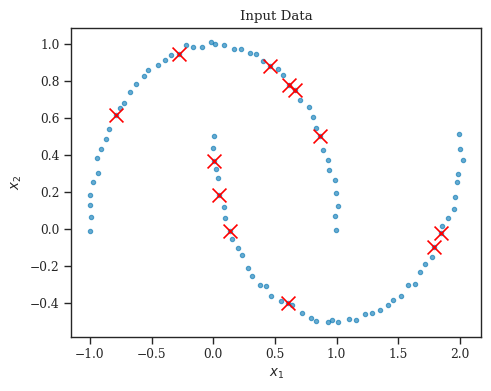

In [23]:
from sklearn.datasets import make_moons
np.random.seed(42)
X, y = make_moons(n_samples=T, noise=0.01)
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.6)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Input Data')

X = X.T
pos = np.random.choice(X.shape[1], size=(K, 1), replace=False)
A = X[:, pos].squeeze()
ax.scatter(A[0], A[1], s=100, c='r', marker='x', label='Atoms')


plt.tight_layout()
fig.show()


NameError: name 'true_Z' is not defined

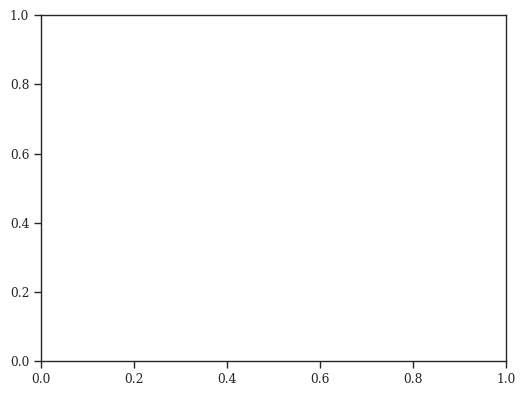

In [7]:
def write_matrix_values(mat, ax):
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=16)
        
        
fig, ax = plt.subplots(figsize=(6, 4.5))

W_opt = 1/T * (true_Z @ X.T)
ax.matshow(W_opt, cmap='YlGn'); ax.grid(False)
write_matrix_values(W_opt, ax); ax.set_title(r'Opt_W')


### Dictionary Learning Simulation

In [70]:
exp_params = {
    'optimizer': {
        'max_epochs': 5000,
        'neuron_max_updates':40,
        'lr': 0.1,
        'lr_neuron': 0.01,
        'lr_param': 0.01,
        'lr_param_Omega': 0.001
    },
    'runtime': runtime_params,
    'model': {
        'lam': 1.0,
        'rho': 5.0,
        'omega': 1.0,
        # 'step': 1e-4
    }
}

Hinv_true = la.inv((1/T)*(true_Z @ true_Z.T) + exp_params['model']['omega'] * np.eye(K))
true_Omega = sqrtm(Hinv_true)
true_step = 0.05 / power_method_svd(torch.from_numpy(true_Omega)).item()

exp_params['model']['step'] = true_step

# Define Model
model = models.SMDL_manifold_ver2(exp_params)

# Define loss
loss_fn = SimilarityLossDL(T=T, lam=exp_params['model']['lam'], rho=exp_params['model']['rho'])


# Define progress bar
pbar = trange(exp_params['optimizer']['max_epochs'])


# Define plot_values
plot_values = {
    'loss': {
        'sim': [],
        'sparsity': [],
        'const_term': [],
        'total': [],
    },
    'lag_loss':{
        'sim': [],
        'sparsity': [],
        'const_term': [],
        'total': [],
    },   
    'neurons': [],
    'parameters': {
        'W': [],
        'M': [],
        'theta': [],
    },
}

for i in pbar:
    
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        
        # Update neuron
    #     # model.update_neurons(X)
        model.update_Z(X)
        # model.update_latent()
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_latent()
        
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_error()    
        # model.update_latent()

    # print(model.step)   

    # model.update_latent() 
        
    model.update_Omega(train=False)
   
      

        
    
    
    
    # model.Hinv = model.compute_Hinv()
    # model.Omega = sqrtm(model.Hinv)
    plot_values['neurons'].append(model._compute_error(model.Omega, model.latent, model.Z))
        
    # # Update parameters
    model.update_parameters(X)
    
    
    # Compute loss
    total, sim, sparsity, const_term = loss_fn.sim_loss_L1_DL_ver2(X, model.latent, model.Z, model.Omega)
    plot_values['loss']['total'].append(total); plot_values['loss']['sim'].append(sim); plot_values['loss']['sparsity'].append(sparsity); plot_values['loss']['const_term'].append(const_term)
    
    pbar.set_description('Loss: {:.4f}'.format(total))
    
    

    

TypeError: power_method_svd() missing 1 required positional argument: 'device'

[[ 6.86321615  6.54352867]
 [-1.60479879 -1.5867038 ]]
[[10.29519395 -2.45109342]
 [-2.45109342  0.63861587]]
[[0.42529109 0.        ]
 [0.         0.40253109]]


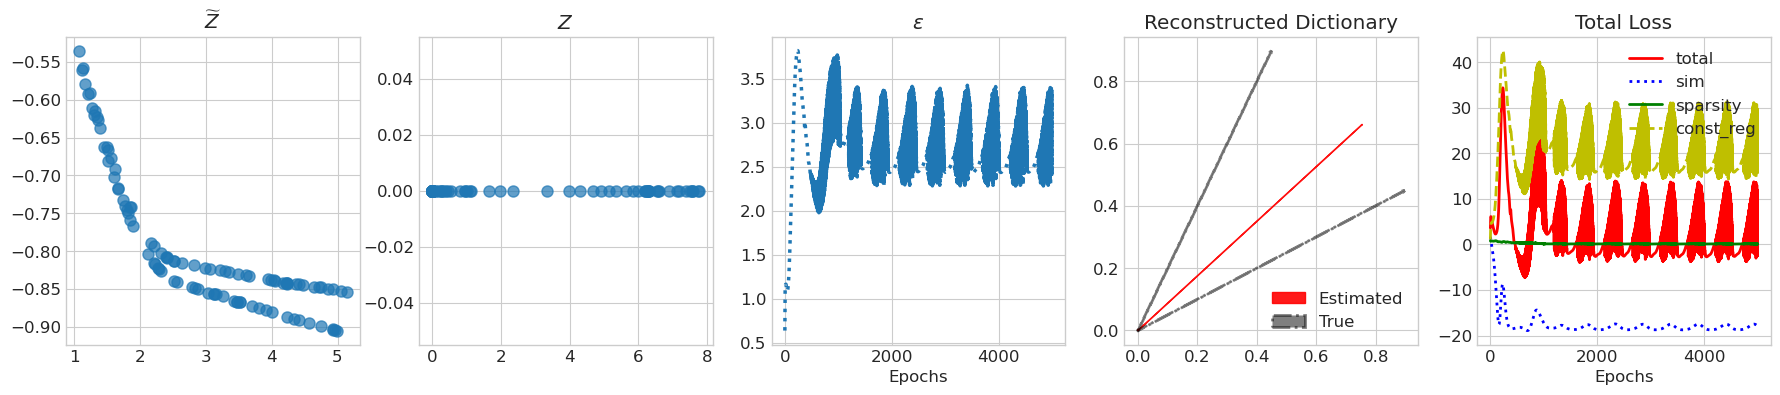

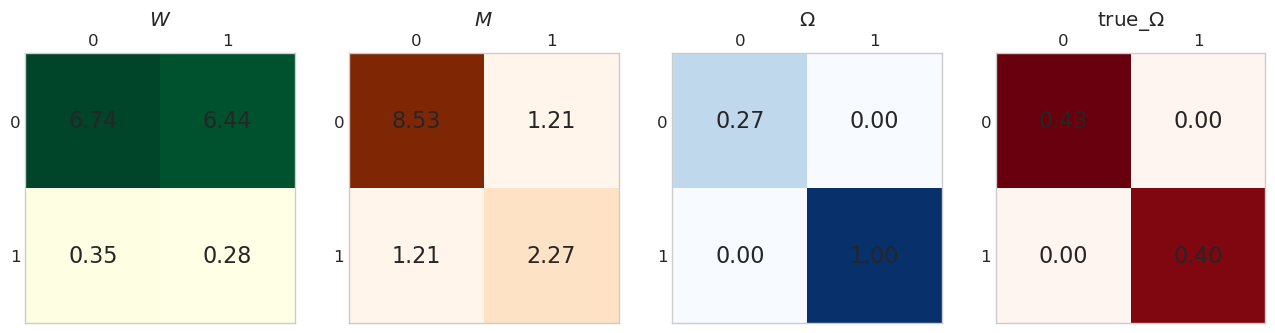

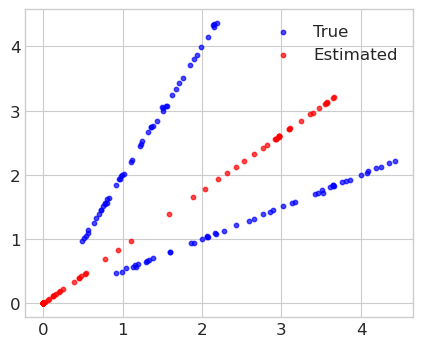

In [14]:
# model.Hinv = model.compute_H()
# model.theta = sqrtm(model.H)
Ahat = (X @ model.latent.T @ model.Hinv)/T
Ahat_norm = Ahat / (np.linalg.norm(Ahat, ord=2, axis=0, keepdims=True)+1e-8)
Xhat = Ahat @ model.latent
# Ahat_norm = la.norm(Ahat, ord=2, axis=0)
# Ahat_norm = np.array([1., 1.])
error_norm = np.linalg.norm(np.array(plot_values['neurons']), axis=1).mean(axis=1)

fig, axs = plt.subplots(1, 5, figsize=(22, 4))
axs[0], scatter_plot_2d(model.Z[0], model.Z[1], ax=axs[0], label=r'$\widetilde{Z}$', alpha=0.7); axs[0].set_title(r'$\widetilde{Z}$')
axs[1], scatter_plot_2d(model.latent[0], model.latent[1], ax=axs[1], label=r'$Z$', alpha=0.7); axs[1].set_title(r'$Z$')
axs[2].plot(error_norm, linestyle='dotted', linewidth=2.5); axs[2].set_title(r'$\epsilon$'); axs[2].set_xlabel('Epochs')
ax = axs[-2]
ax.arrow(0, 0, np.abs(Ahat_norm[0,0]), np.abs(Ahat_norm[1,0]), color='r', label='Estimated', alpha=0.9)
ax.arrow(0, 0, np.abs(Ahat_norm[0,1]), np.abs(Ahat_norm[1,1]), color='r', alpha=0.9)
ax.arrow(0, 0, A[0,0], A[1,0], color='k', ls='-.', lw=2, label='True', alpha=0.5)
ax.arrow(0, 0, A[0,1], A[1,1], color='k', ls='-.', lw=2, alpha=0.5)
ax.set_title('Reconstructed Dictionary')
ax.legend()

axs[-1].plot(plot_values['loss']['total'], label='total', c='r')
axs[-1].plot(plot_values['loss']['sim'], label='sim', c='b', linestyle='dotted')
axs[-1].plot(plot_values['loss']['sparsity'], label='sparsity', c='g')
axs[-1].plot(plot_values['loss']['const_term'], label='const_reg', c='y', linestyle='dashed')
axs[-1].set_title('Total Loss')
axs[-1].legend()
axs[-1].set_xlabel('Epochs')
fig.show()


fig, axs = plt.subplots(1, 4, figsize=(16, 4))
true_Omega = sqrtm(la.inv((1/model.T) * (true_Z @ true_Z.T) + (model.omega) * np.eye(model.K)))
axs[0].matshow(model.W, cmap='YlGn'); axs[0].grid(False); axs[0].set_title(r'$W$'); write_matrix_values(model.W, axs[0])
axs[1].matshow(model.M, cmap='Oranges'); axs[1].grid(False); axs[1].set_title(r'$M$'); write_matrix_values(model.M, axs[1])
axs[2].matshow(model.Omega, cmap='Blues'); axs[2].grid(False); axs[2].set_title(r'$\Omega$'); write_matrix_values(model.Omega, axs[2])
axs[3].matshow(true_Omega, cmap='Reds'); axs[3].grid(False); axs[3].set_title(r'true_$\Omega$'); write_matrix_values(true_Omega, axs[3])
fig.show()
print((1/model.T)* (model.Z @ X.T))
print((1/model.T)* (model.Z @ model.Z.T))
print(sqrtm(la.inv((1/model.T) * (true_Z @ true_Z.T) + (model.omega) * np.eye(model.K))))

fig, ax = plt.subplots(figsize = (5, 4))
ax, scatter_plot_2d(X[0], X[1], ax=ax, label=r'True', alpha=0.7, c='b', s=10)
ax, scatter_plot_2d(Xhat[0], Xhat[1], ax=ax, label=r'Estimated', alpha=0.7, c='r', s=10)
ax.legend()


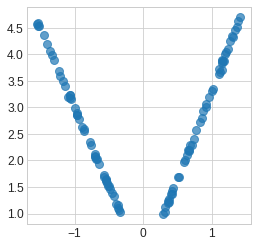

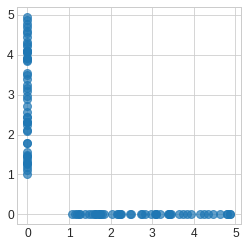

In [89]:
# Equilibrim Zt theoretical

Zt_theo = np.linalg.inv(model.M) @ (model.W @ X - model.error)
# Zt_theo = np.linalg.inv(model.M + model.rho * model.theta.T @ model.theta) @ (model.W.T  @ X - model.rho*model.theta.T @ model.latent)
Z_theo = true_Z
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax, scatter = scatter_plot_2d(Zt_theo[0], Zt_theo[1], ax=ax, label=r'$\widetilde{Z}$', alpha=0.7)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax, scatter = scatter_plot_2d(Z_theo[0], Z_theo[1], ax=ax, label=r'$Z$', alpha=0.7)

### Dictionary Learning with Omega updated

(2, 12)

In [46]:
from src.models_old import SMDL_manifold_ver2

In [51]:

exp_params = {
    'optimizer': {
        'max_epochs': 10000,
        'neuron_max_updates':20,
        'lr': 0.1,
        'lr_neuron': 0.01,
        'lr_param': 0.1,
        'lr_param_Omega': 0.001
    },
    'runtime': runtime_params,
    'model': {
        'lam': 0.001,
        'rho': 0.5,
        'omega': 0.5,
        # 'step': 1e-6
    }
}
initZ = np.random.randn(K, T)

Hinv_init = la.inv((1/T) * (initZ @ initZ.T) +  exp_params['model']['omega'] * np.diag(initZ.mean(axis=1)))
Omega_init = sqrtm(Hinv_init)
step_init = 0.5 / power_method_svd(torch.from_numpy(Omega_init).float(), device='cpu').item()
print(step_init)

exp_params['model']['step'] = step_init

# Define model
model = models.SMDL_manifold_ver2(exp_params, Z=initZ, W=A.T)

# Define loss
loss_fn = SimilarityLossDL(T=T, omega=exp_params['model']['omega'], rho=exp_params['model']['rho'])

# true_loss = SMPC_loss(T=T, lam=exp_params['model']['lam'], rho=exp_params['model']['rho'])


plot_values = {
    'loss': {
        'sim': [],
        # 'sparsity': [],
        'const_term': [],
        'total': []
    },
    # 'true_loss': {
    #     'sim': [],
    #     'sparsity': [],
    #     'total': []
    # },
    'neurons': [],
    'parameters': [], 
    'symm_Omega': [],
    'Hinv_diff': [],
    'Hinv_th': []
}


pbar = trange(exp_params['optimizer']['max_epochs'])

for i in pbar:
    
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_Z(X, fixed=False)

    

    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_latent()

        
    for j in range(exp_params['optimizer']['neuron_max_updates']):
        model.update_error()


    
    # Update parameters
    model.update_parameters(X, fixed=False) # update W, M
    model.update_Omega(train=True, const=True)
    

    
    plot_values['neurons'].append(model.return_neurons())  
    plot_values['parameters'].append(model.return_parameters())
    
    total, sim, const_term = loss_fn.sim_loss_manifold_DL_ver2(X, model.latent, model.Z, model.Omega)
    
    plot_values['symm_Omega'].append(np.linalg.norm(model.Omega - model.Omega.T))
    
    plot_values['Hinv_th'].append(np.linalg.norm(model.H_inv_th - model.Hinv))
    # plot_values['Hinv_diff'].append(np.linalg.norm( - model.Hinv))
    
    plot_values['loss']['total'].append(total); plot_values['loss']['sim'].append(sim); 
    # plot_values['loss']['sparsity'].append(sparsity); 
    plot_values['loss']['const_term'].append(const_term)
    
    # H = la.inv(model.H_inv_th)
    H = la.inv(model.Hinv)
    # total, sim, sparsity = true_loss.L1_loss(X, model.latent, H)
    # plot_values['true_loss']['total'].append(total); plot_values['true_loss']; plot_values['true_loss']['sim'].append(sim); plot_values['true_loss']['sparsity'].append(sparsity)
    
    pbar.set_description(f"Loss: {total:.2f}")
    
    # if (i==20): 
    #     break
    





0.22558268614332122


Loss: -0.21: 100%|██████████| 10000/10000 [10:57<00:00, 15.20it/s]


In [52]:
# Generate plots
Ahat = (X @ model.latent.T @ model.Hinv) / model.T
# Ahat_n = Ahat / np.linalg.norm(Ahat, axis=0, keepdims=True)
Xhat = Ahat @ model.latent

error_norm = np.array([np.mean(np.linalg.norm(plot_values['neurons'][i]['error'], axis=0, keepdims=True)) for i in range(len(plot_values['neurons']))])



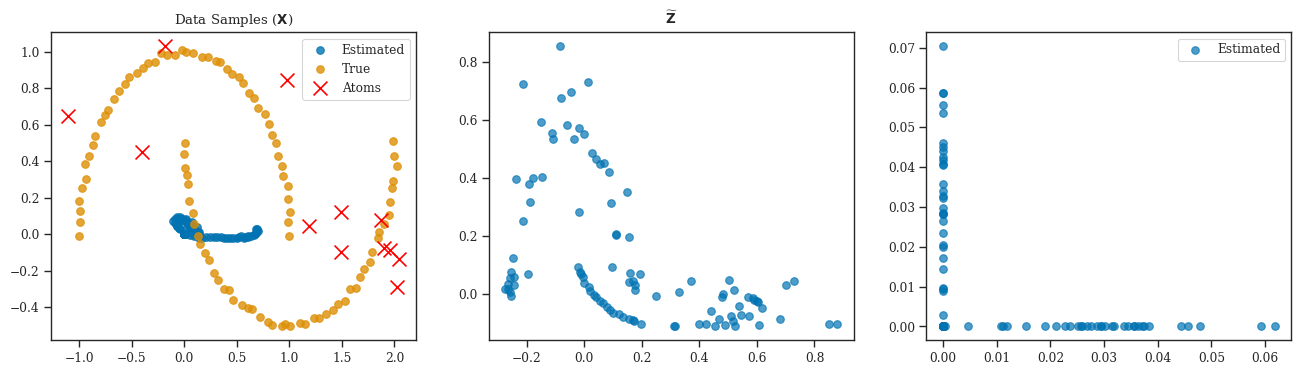

In [53]:


# Plot neurons
fig, axs = plt.subplots(1, 3,  figsize=(16,4))
ax = axs[1]
ax, scatter = scatter_plot_2d(model.Z[0], model.Z[1], ax=ax, alpha=0.7, s=30); ax.set_title(r'$\mathbf{\widetilde{Z}}$')

ax = axs[-1]
ax, scatter = scatter_plot_2d(np.abs(model.latent[0]), np.abs(model.latent[1]), ax=ax, label='Estimated', alpha=0.7, s=30);
# ax, scatter = scatter_plot_2d(true_Z[0], true_Z[1], ax=ax, label='True', alpha=0.7, s=30); ax.set_title('Representations ($\mathbf{Z}$)')
ax.legend()
# axs[2].plot(error_norm, label='$||\epsilon||$'); axs[2].set_xlabel('Epochs'); axs[2].legend()
ax = axs[0]
ax, scatter = scatter_plot_2d(Xhat[0], Xhat[1], ax=ax, label=r'Estimated', alpha=0.8, s=30)
ax, scatter = scatter_plot_2d(X[0], X[1], ax=ax, label=r'True', alpha=0.8, s=30)
ax.scatter(Ahat[0], Ahat[1], s=100, c='r', marker='x', label='Atoms')
ax.set_title('Data Samples ($\mathbf{X}$)')
ax.legend()
# plt.savefig('../figures/smpc_reconstruction.pdf', bbox_inches='tight')
fig.show()



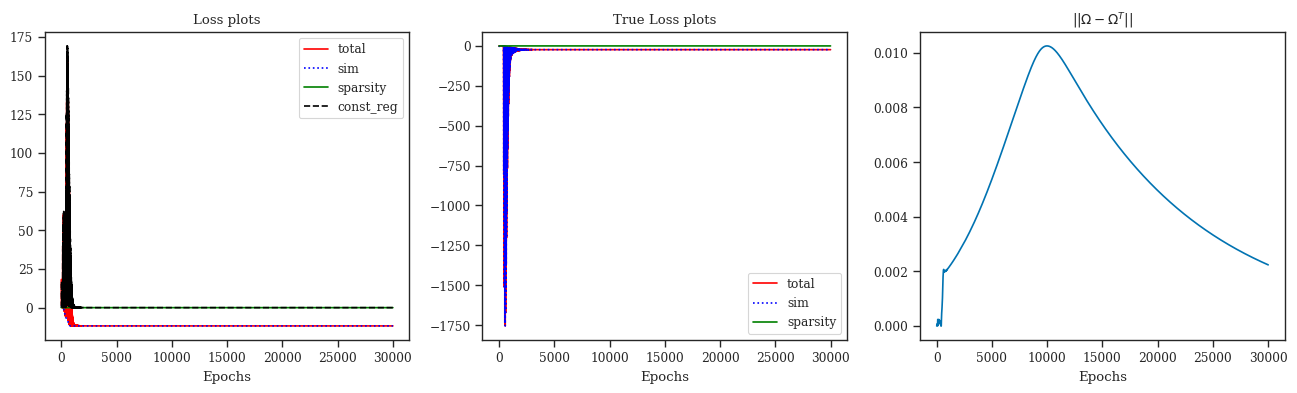

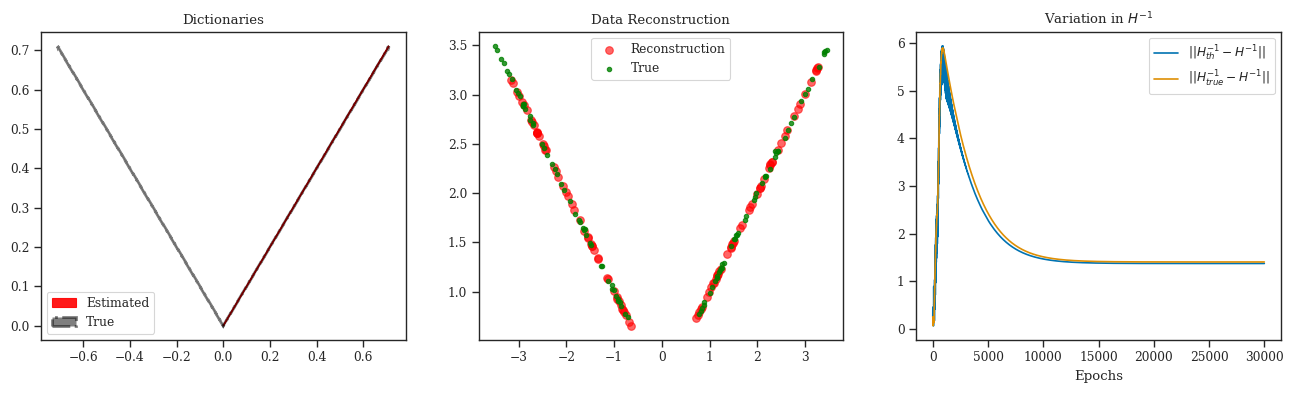

In [76]:

fig, axs  = plt.subplots(1, 3, figsize=(16, 4))
ax = axs[0]

ax.plot(plot_values['loss']['total'], label='total', c='r')
ax.plot(plot_values['loss']['sim'], label='sim', c='b', linestyle='dotted')
ax.plot(plot_values['loss']['sparsity'], label='sparsity', c='g')
ax.plot(plot_values['loss']['const_term'], label='const_reg', c='k', linestyle='dashed')
ax.set_title('Loss plots')
ax.legend()
ax.set_xlabel('Epochs')


ax = axs[1]
ax.plot(plot_values['true_loss']['total'], label='total', c='r')
ax.plot(plot_values['true_loss']['sim'], label='sim', c='b', linestyle='dotted')
ax.plot(plot_values['true_loss']['sparsity'], label='sparsity', c='g')
ax.set_title('True Loss plots')
ax.legend()
ax.set_xlabel('Epochs')

ax = axs[2]
ax.plot(plot_values['symm_Omega'], label=r'$||\Omega - \Omega^T||$'); ax.set_title(r'$||\Omega - \Omega^T||$'); ax.set_xlabel('Epochs')


fig, axs = plt.subplots(1, 3, figsize=(16,4))
ax = axs[0]
ax.arrow(0, 0, np.abs(Ahat_n[0,0]), np.abs(Ahat_n[1,0]) , color='r', label='Estimated', alpha=0.9)
ax.arrow(0, 0, np.abs(Ahat_n[0,1]), np.abs(Ahat_n[1,1]), color='r', alpha=0.9)
ax.arrow(0, 0, A[0,0], A[1,0], color='k', label='True', alpha=0.5, ls='-.', lw=2)
ax.arrow(0, 0, A[0,1], A[1,1], color='k', alpha=0.5, ls='-.', lw=2)
ax.legend()
ax.set_title('Dictionaries')
fig.show()
ax = axs[1]
ax, scatter = scatter_plot_2d(Xhat[0], Xhat[1], ax=ax, label=r'Reconstruction', alpha=0.6, c='r', s=30)
ax, scatter = scatter_plot_2d(X[0], X[1], ax=ax, label=r'True', alpha=0.8, c='g', s=10)
ax.legend()
ax.set_title('Data Reconstruction')

ax = axs[2]
ax.plot(plot_values['Hinv_th'], label=r'$||H^{-1}_{th} - H^{-1}||$'); ax.set_xlabel('Epochs')
ax.plot(plot_values['Hinv_diff'], label=r'$||H^{-1}_{true} - H^{-1}||$'); ax.set_title(r'Variation in $H^{-1}$'); ax.set_xlabel('Epochs')
ax.legend()



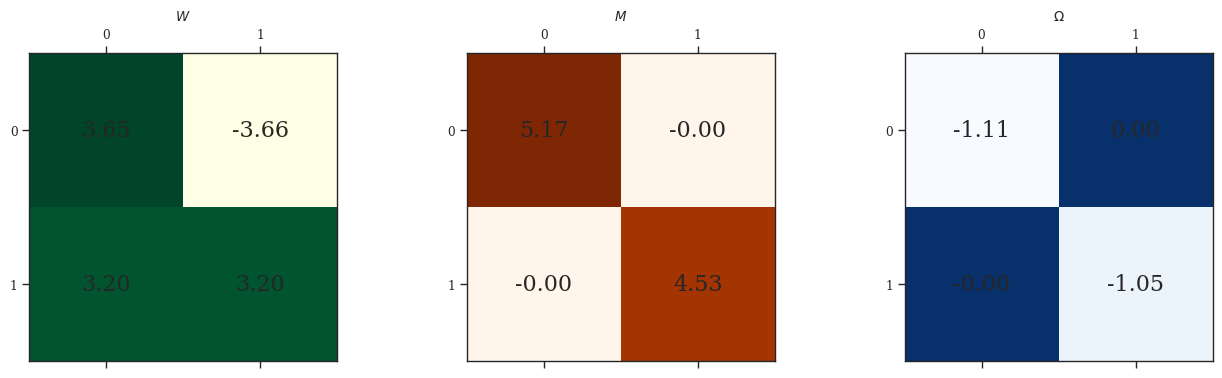

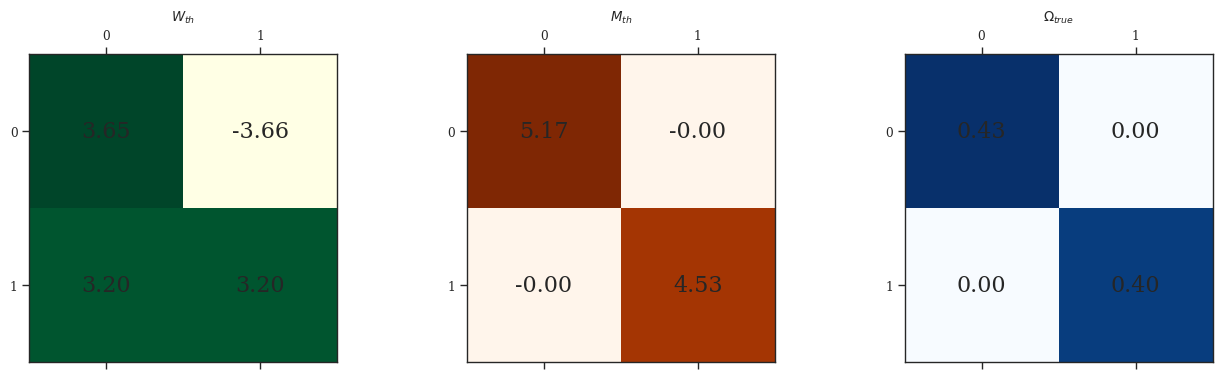

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
ax = axs[0]
ax.matshow(model.W, cmap='YlGn'); ax.grid(False); ax.set_title(r'$W$'); write_matrix_values(model.W, ax)
ax = axs[1]
ax.matshow(model.M, cmap='Oranges'); ax.grid(False); ax.set_title(r'$M$'); write_matrix_values(model.M, ax)
ax = axs[2]
ax.matshow(model.Omega, cmap='Blues'); ax.grid(False); ax.set_title(r'$\Omega$'); write_matrix_values(model.Omega, ax)


fig, axs = plt.subplots(1, 3, figsize=(16,4))
W_th = (1/model.T) * (model.Z @ X.T)
ax = axs[0]
ax.matshow(W_th, cmap='YlGn'); ax.grid(False); ax.set_title(r'$W_{th}$'); write_matrix_values(W_th, ax)
M_th = (1/model.T) * (model.Z @ model.Z.T)
ax = axs[1]
ax.matshow(M_th, cmap='Oranges'); ax.grid(False); ax.set_title(r'$M_{th}$'); write_matrix_values(M_th, ax)
# true_H = ((1/model.T) * true_Z @ true_Z.T) + model.omega * np.eye(true_Z.shape[0])
ax = axs[2]
ax.matshow(true_Omega, cmap='Blues'); ax.grid(False); ax.set_title(r'$\Omega_{true}$'); write_matrix_values(true_Omega, ax)